Loading Data from Kaggle Datasets


In [0]:
from google.colab import files

!pip install -q kaggle

In [7]:
cd root/.kaggle

/root/.kaggle


In [8]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [9]:
cd /content

/content


In [10]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.15G/1.15G [00:13<00:00, 49.9MB/s]
100% 1.15G/1.15G [00:13<00:00, 92.0MB/s]


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

test/  train/  val/


Extracting the images from the zip file


In [0]:
import zipfile
with zipfile.ZipFile("chest-xray-pneumonia.zip") as zip_ref:
  zip_ref.extractall()

In [0]:
with zipfile.ZipFile("chest_xray.zip") as zip_ref:
  zip_ref.extractall()

Importing the required libraries

In [0]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
import os
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, log_loss, classification_report
from random import shuffle
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, Dropout, Activation, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [15]:
print(os.listdir('../content/chest_xray/'))
TRAIN_NORMAL_DIR = '../content/chest_xray/train/NORMAL'
TRAIN_PNEUM_DIR = '../content/chest_xray/train/PNEUMONIA'
TEST_NORMAL_DIR = '../content/chest_xray/test/NORMAL'
TEST_PNEUM_DIR = '../content/chest_xray/test/PNEUMONIA'
VAL_NORMAL_DIR = '../content/chest_xray/val/NORMAL'
VAL_PNEUM_DIR = '../content/chest_xray/val/PNEUMONIA'

['test', '.DS_Store', 'train', 'val']


Loading the images and converting them into numpy arrays

In [16]:
X_train = []
X_test = []
X_val = []
y_train = []
y_test = []
y_val = []

def convert_images(dir, categ):
  for img in tqdm(os.listdir(dir)):
    if (img == '.DS_Store'):
      continue;
    path = os.path.join(dir, img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150, 150))
    if (dir.find('train') >= 0 or dir.find('val') >= 0):
      X_train.append(np.array(img))
      y_train.append(categ)
    elif (dir.find('test') >= 0):
      X_test.append(np.array(img))
      y_test.append(categ)
    #else:
    #  X_val.append(np.array(img))
    #  y_val.append(categ)

convert_images(TRAIN_NORMAL_DIR, "normal");
convert_images(TRAIN_PNEUM_DIR, "pneumonia");
convert_images(TEST_NORMAL_DIR, "normal");
convert_images(TEST_PNEUM_DIR, "pneumonia");
convert_images(VAL_NORMAL_DIR, "normal");
convert_images(VAL_PNEUM_DIR, "pneumonia");


100%|██████████| 9/9 [00:00<00:00, 135.79it/s]


In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)
#X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
#y_val = np.array(y_val)

In [108]:
print(X_train.shape)
print(X_test.shape)
#print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
#print(y_val.shape)

(3924, 150, 150, 3)
(624, 150, 150, 3)
(3924, 2)
(624, 2)


Rescaling X data and performing one-hot encoding on y data 


In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

#y_val = le.fit_transform(y_val)

In [0]:
X_train = X_train/255
X_test = X_test/255
#X_val = X_val/255

Visualizing some of the x-rays

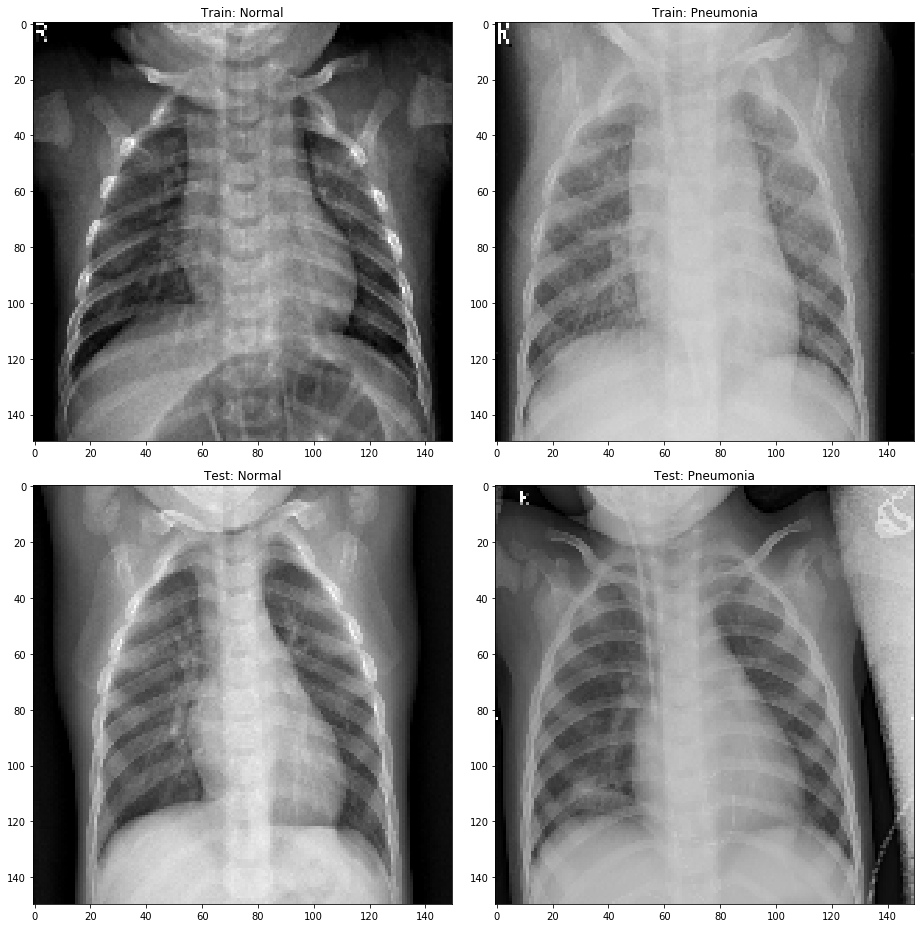

In [21]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(13, 13)

ax[0, 0].imshow(X_train[0])
ax[0, 0].set_title("Train: "+("Pneumonia" if y_train[0] else "Normal"))
ax[1, 0].imshow(X_test[0])
ax[1, 0].set_title("Test: "+("Pneumonia" if y_test[0] else "Normal"))
#ax[2, 0].imshow(X_val[0])
#ax[2, 0].set_title("Val: "+("Pneumonia" if y_val[0] else "Normal"))

ax[0, 1].imshow(X_train[-1])
ax[0, 1].set_title("Train: "+("Pneumonia" if y_train[-1] else "Normal"))
ax[1, 1].imshow(X_test[-1])
ax[1, 1].set_title("Test: "+("Pneumonia" if y_test[-1] else "Normal"))
#ax[2, 1].imshow(X_val[-1])
#ax[2, 1].set_title("Val: "+("Pneumonia" if y_val[-1] else "Normal"))

plt.tight_layout()

Splitting training data into training and validation

In [0]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size = 0.25,
                                                  random_state = 42)

In [24]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(3924, 150, 150, 3)
(1308, 150, 150, 3)
(3924, 2)
(1308, 2)


Performing transfer learning using Inception V3 or VGG16

In [0]:

base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (150, 150, 3), pooling = 'avg')
#base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (150, 150, 3), pooling = 'avg')

In [124]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
model = Sequential()
model.add(base_model)
model.add(Dropout(0.25))
#model.add(Dense(256, activation = 'relu'))
#model.add(Dropout(0.25))
#model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(2, activation = 'softmax'))

In [128]:
epochs = 50
batch_size = 128
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
base_model.trainable = False
#optimizer = RMSprop(lr = 0.001, rho = 0.9)
optimizer = Adam()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [0]:
ls

chest_xray/  chest-xray-pneumonia.zip  chest_xray.zip  __MACOSX/  sample_data/


In [129]:
checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train, 
          validation_data=(X_val, y_val),
          epochs = epochs, batch_size = batch_size, 
          callbacks=[checkpointer], verbose=1)

Train on 3924 samples, validate on 1308 samples
Epoch 1/50
3924/3924 [==============================] - 37s 9ms/step - loss: 0.5623 - acc: 0.7337 - val_loss: 0.5052 - val_acc: 0.7217

Epoch 00001: val_loss improved from inf to 0.50520, saving model to weights.best.hdf5
Epoch 2/50
3924/3924 [==============================] - 24s 6ms/step - loss: 0.4634 - acc: 0.7775 - val_loss: 0.4265 - val_acc: 0.7607

Epoch 00002: val_loss improved from 0.50520 to 0.42649, saving model to weights.best.hdf5
Epoch 3/50
3924/3924 [==============================] - 24s 6ms/step - loss: 0.3919 - acc: 0.8178 - val_loss: 0.3749 - val_acc: 0.8402

Epoch 00003: val_loss improved from 0.42649 to 0.37489, saving model to weights.best.hdf5
Epoch 4/50
3924/3924 [==============================] - 24s 6ms/step - loss: 0.3531 - acc: 0.8484 - val_loss: 0.3409 - val_acc: 0.8540

Epoch 00004: val_loss improved from 0.37489 to 0.34091, saving model to weights.best.hdf5
Epoch 5/50
3924/3924 [==============================

Model accuracy and log-loss for test data 

In [130]:
model.load_weights('weights.best.hdf5')
#np.argmax(model.predict(X_test), axis = 1)
#np.argmax(y_test, axis = 1)
predicted = model.predict(X_test)
print("Test Accuracy Score = ", accuracy_score(np.argmax(y_test, axis = 1), 
                                 np.argmax(predicted, axis = 1)))
print("Test Log Loss = ", log_loss(y_test, 
                                   model.predict(X_test)))


Test Accuracy Score =  0.8012820512820513
Test Log Loss =  0.4400379446084781


Trying out the model on test images

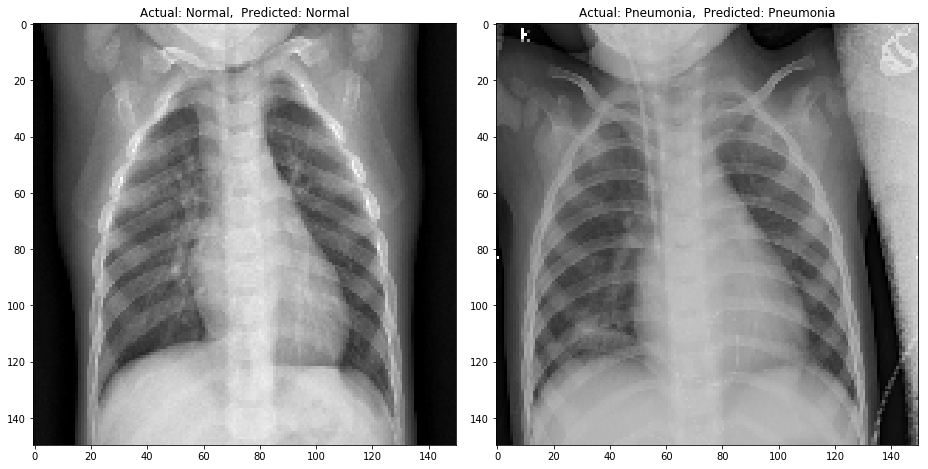

In [131]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(13, 13)
ax[0].imshow(X_test[0])

ax[0].set_title("Actual: "+("Pneumonia" if np.argmax(y_test[0], axis = 0) else "Normal")+
                   ",  Predicted: "+("Pneumonia" if np.argmax(predicted[0], axis = 0) else "Normal"))

ax[1].imshow(X_test[-1])
ax[1].set_title("Actual: "+("Pneumonia" if np.argmax(y_test[-1], axis = 0) else "Normal")+
                   ",  Predicted: "+("Pneumonia" if np.argmax(predicted[-1], axis = 0) else "Normal"))



plt.tight_layout()

In [132]:
print(classification_report(np.argmax(y_test, axis = 1),
                            np.argmax(predicted, axis = 1)))

              precision    recall  f1-score   support

           0       0.97      0.49      0.65       234
           1       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.75       624
weighted avg       0.84      0.80      0.78       624



In [133]:
#model.to_json()
files.download("weights.best.hdf5")

MessageError: ignored

In [0]:
with open("model1.json","w") as json_file:
     json_file.write(model.to_json())

In [135]:
files.download("model1.json")

MessageError: ignored